# Setup

Load requirements

In [36]:
import os
import gc
import torch
import scipy
import random
import torchvision
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import deeplab.network as network
import torchvision.models as models
import torch.nn.functional
import torch.nn.functional as F
import torchvision.transforms.functional as FUNC

from PIL import Image
from torchvision.transforms import RandomCrop
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_recall_curve, auc

Select device

In [2]:
device = "cpu"
if torch.cuda.is_available():
  device = torch.device("cuda:5")
print(f"Using device: {device}\n")

Using device: cuda:5



In [3]:

class NormedConv(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, scale=1.0, margin=0.0, dilation=1, groups=1, bias=False, padding_mode='zeros', device=None, dtype=None):
        super(NormedConv, self).__init__(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias, padding_mode, device=device, dtype=dtype)
        self.scale = scale
        self.margin = margin

    def forward(self, x):
        # Normalizza i pesi lungo la dimensione dei filtri (output channels)
        norm_weight = F.normalize(self.weight, p=2, dim=1)
        # Normalizza l'input lungo la dimensione dei canali (dim=1)
        norm_x = F.normalize(x, p=2, dim=1)
        # Chiama il forward con input e pesi normalizzati
        return self.scale * F.conv2d(norm_x, norm_weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

class PrototypeHead(nn.Module):
    def __init__(self, embed_dim, num_prototypes):
        super().__init__()
        self.prototypes = nn.Parameter(torch.randn(num_prototypes, embed_dim))
        nn.init.xavier_normal_(self.prototypes)
    
    def forward(self, x):
        B, D, H, W = x.shape
        x_flat = x.permute(0, 2, 3, 1).reshape(-1, D)

        dists = torch.cdist(x_flat, self.prototypes, p=2).pow(2)
        dists = dists.view(B, H, W, -1).permute(0, 3, 1, 2)
        
        return -dists

class PrototypeHeadMLP(nn.Module):
    def __init__(self, embed_dim: int, hidden_dims: list, num_prototypes: int):
        super().__init__()
        
        # 1) Prototipi nello spazio originale (es. 256)
        self.prototypes = nn.Parameter(torch.randn(num_prototypes, embed_dim))
        
        # 2) MLP come serie di conv1x1 + ReLU
        #    (equivale a una MLP su ogni pixel in parallelo)
        layers = []
        in_channels = embed_dim
        for out_channels in hidden_dims:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=1))
            layers.append(nn.ReLU(inplace=True))
            in_channels = out_channels
        
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        """
        x: Tensor shape (B, embed_dim, H, W)
        Ritorna: Tensor shape (B, num_prototypes, H, W) con i logits = -distanza
        """
        # 1) Trasforma le feature del backbone in uno spazio nascosto
        x = self.mlp(x)
        
        # 2) Trasforma i prototipi con la stessa MLP (f(w_c))
        proto = self.prototypes.unsqueeze(-1).unsqueeze(-1)
        proto = self.mlp(proto)
        proto = proto.view(proto.size(0), -1)
        
        # 3) Distanza
        B, D2, H, W = x.shape
        x_flat = x.permute(0, 2, 3, 1).reshape(-1, D2)
        
        dists = torch.cdist(x_flat, proto, p=2).pow(2)
        dists = dists.view(B, H, W, -1).permute(0, 3, 1, 2)

        return -dists
    
class PrototypeHeadMLP2(nn.Module):
    def __init__(self, embed_dim: int, hidden_dims: list, num_prototypes: int):
        super().__init__()
        
        # 1) Prototipi nello spazio originale (es. 256)
        self.prototypes = nn.Parameter(torch.randn(num_prototypes, hidden_dims[-1]))
        
        # 2) MLP come serie di conv1x1 + ReLU
        #    (equivale a una MLP su ogni pixel in parallelo)
        layers = []
        in_channels = embed_dim
        for out_channels in hidden_dims:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=1))
            layers.append(nn.ReLU(inplace=True))
            in_channels = out_channels
        
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        """
        x: Tensor shape (B, embed_dim, H, W)
        Ritorna: Tensor shape (B, num_prototypes, H, W) con i logits = -distanza
        """
        # 1) Trasforma le feature del backbone in uno spazio nascosto
        x = self.mlp(x)
        
        # 3) Distanza
        B, D2, H, W = x.shape
        x_flat = x.permute(0, 2, 3, 1).reshape(-1, D2)
        
        dists = torch.cdist(x_flat, self.prototypes, p=2).pow(2)
        dists = dists.view(B, H, W, -1).permute(0, 3, 1, 2)

        return -dists
    
class PrototypeHeadArcFace(nn.Module):
    def __init__(self, embed_dim: int, hidden_dims: list, num_prototypes: int):
        super().__init__()
        
        # 1) Prototipi nello spazio finale
        self.prototypes = nn.Parameter(torch.randn(num_prototypes, embed_dim))
        
        # 2) MLP per trasformare le feature (equivalente a una MLP per pixel)
        layers = []
        in_channels = embed_dim
        for out_channels in hidden_dims:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=1))
            layers.append(nn.ReLU(inplace=True))
            in_channels = out_channels
        
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        
        # 1) Trasforma le feature con la MLP
        x = self.mlp(x)
        
        # 2) Normalizziamo le feature pixel-wise
        B, D2, H, W = x.shape
        x_flat = x.permute(0, 2, 3, 1).reshape(-1, D2)
        x_flat = F.normalize(x_flat, p=2, dim=1)

        # 3) Trasforma i prototipi con la stessa MLP (f(w_c))
        proto = self.prototypes.unsqueeze(-1).unsqueeze(-1)
        proto = self.mlp(proto)
        proto = proto.view(proto.size(0), -1)

        # 4) Normalizziamo i prototipi
        proto = F.normalize(proto, p=2, dim=1)
        
        # 5) Prodotto scalare normalizzato tra feature e prototipi
        logits = torch.mm(x_flat, proto.T)

        # 6) Reshape a (B, num_prototypes, H, W)
        logits = logits.view(B, H, W, -1).permute(0, 3, 1, 2)  
        
        return logits

class PrototypeHeadArcFace2(nn.Module):
    def __init__(self, embed_dim: int, hidden_dims: list, num_prototypes: int):
        super().__init__()
        
        # 1) Prototipi nello spazio finale
        self.prototypes = nn.Parameter(torch.randn(num_prototypes, hidden_dims[-1]))
        
        # 2) MLP per trasformare le feature (equivalente a una MLP per pixel)
        layers = []
        in_channels = embed_dim
        for out_channels in hidden_dims:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=1))
            layers.append(nn.ReLU(inplace=True))
            in_channels = out_channels
        
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        
        # 1) Trasforma le feature con la MLP
        x = self.mlp(x)
        
        # 2) Normalizziamo le feature pixel-wise
        B, D2, H, W = x.shape
        x_flat = x.permute(0, 2, 3, 1).reshape(-1, D2)
        x_flat = F.normalize(x_flat, p=2, dim=1)

        # 3) Normalizziamo i prototipi
        proto = F.normalize(self.prototypes, p=2, dim=1)
        
        # 5) Prodotto scalare normalizzato tra feature e prototipi
        logits = torch.mm(x_flat, proto.T)

        # 6) Reshape a (B, num_prototypes, H, W)
        logits = logits.view(B, H, W, -1).permute(0, 3, 1, 2)  
        
        return logits
     

# Dataset

Define classes

In [4]:
class RandomCropSync:
    def __init__(self, size):
        self.size = size

    def __call__(self, img, mask):
        # Ottieni i parametri per il ritaglio casuale
        i, j, h, w = RandomCrop.get_params(img, output_size=self.size)
        # Applica il ritaglio sia all'immagine che alla maschera
        img = FUNC.crop(img, i, j, h, w)
        mask = FUNC.crop(mask, i, j, h, w)
        return img, mask

class RandomHorizontalFlipSync:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, mask):
        if random.random() < self.p:
            img = FUNC.hflip(img)
            mask = FUNC.hflip(mask)
        return img, mask
    
class ToTensorSync:
    def __call__(self, img, mask):
        # Converti l'immagine in un tensore normalizzato
        img_tensor = FUNC.to_tensor(img)
        
        # Converti la maschera in un tensore grezzo senza normalizzazione
        mask_tensor = FUNC.pil_to_tensor(mask)
        
        return img_tensor, mask_tensor
    
class NormalizeSync:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, img, mask):
        img = FUNC.normalize(img, mean=self.mean, std=self.std)
        return img, mask
        
class ComposeSync:
    """
    Composizione di trasformazioni che accettano immagine e maschera.
    """
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, mask):
        for transform in self.transforms:
            img, mask = transform(img, mask)
        return img, mask

class TopScoringCrop:
    def __init__(self, size, freqs):
        self.size = size
        self.freqs = torch.tensor(freqs)

    def calculate_iou(self, box1, box2):
        side = self.size
        x1_min, y1_min = box1
        x1_max, y1_max = box1[0] + side, box1[1] + side

        x2_min, y2_min = box2
        x2_max, y2_max = box2[0] + side, box2[1] + side

        inter_x_min = max(x1_min, x2_min)
        inter_y_min = max(y1_min, y2_min)
        inter_x_max = min(x1_max, x2_max)
        inter_y_max = min(y1_max, y2_max)

        inter_area = max(0, inter_x_max - inter_x_min) * max(0, inter_y_max - inter_y_min)
        box_area = side * side
        union_area = 2 * box_area - inter_area

        return inter_area / union_area if union_area > 0 else 0

    def filter_squares(self, vertices, threshold=0.5):
        filtered = [vertices[0]]
        for idx in range(1, len(vertices)):
            iou = max(self.calculate_iou(x, vertices[idx]) for x in filtered)
            if iou <= threshold:
                filtered.append(vertices[idx])
        return filtered

    def __call__(self, img, mask):
        scores = self.freqs[mask.type(torch.int64)-1].squeeze()

        values = []
        indices = []
        for x in range(0, mask.shape[1] - self.size, 40):
            for y in range(0, mask.shape[2] - self.size, 40):
                value = scores[x:x + self.size, y:y + self.size].sum().item()
                values.append(value)
                indices.append((x, y))

        sorted_indices = [obj for _, obj in sorted(zip(values, indices), reverse=True)]
        sorted_indices = self.filter_squares(sorted_indices, threshold=0.3)

        # Select the top scoring crop
        top_index = sorted_indices[random.randint(0,min(3,len(sorted_indices)))]
        img_crop = FUNC.crop(img, top_index[0], top_index[1], self.size, self.size)
        mask_crop = FUNC.crop(mask, top_index[0], top_index[1], self.size, self.size)

        return img_crop, mask_crop

class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transforms=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transforms = transforms
        self.image_filenames = sorted(os.listdir(images_dir))
        self.mask_filenames = sorted(os.listdir(masks_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_filenames[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transforms:
            image, mask = self.transforms(image, mask)

        mask = mask.squeeze(0)
        mask = mask.type(torch.int64)-1

        return image, mask

Create dataset

In [5]:
path_test = './data/test'
path_test_images            =  path_test + '/images/test/t5'
path_test_masks             =  path_test + '/annotations/test/t5'
path_test_anomaly_images    =  path_test + '/images/test/t6'
path_test_anomaly_masks     =  path_test + '/annotations/test/t6'

# Trasformazioni
transforms = ComposeSync([
    ToTensorSync(),
    NormalizeSync(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Training dataset
dataset_test = SegmentationDataset(
    images_dir = path_test_images,
    masks_dir = path_test_masks,
    transforms = transforms
)

# Validation dataset
dataset_test_anomaly = SegmentationDataset(
    images_dir = path_test_anomaly_images,
    masks_dir = path_test_anomaly_masks,
    transforms = transforms
)

print("Dataset Creati")
print(f"Test images: {len(dataset_test)}")
print(f"Anomalies images: {len(dataset_test_anomaly)}\n")

Dataset Creati
Test images: 1024
Anomalies images: 476



# Added

In [6]:
# region DATASET
path_train = '/raid/homespace/piecestola/space/ML4CV/data/train'
path_train_images =  path_train + '/images/training/t1-3'
path_valid_images =  path_train + '/images/validation/t4'
path_train_masks  =  path_train + '/annotations/training/t1-3'
path_valid_masks  =  path_train + '/annotations/validation/t4'

freqs = [3.223254919052124, 8.324562072753906, 1000.07819366455078, 214.23089599609375, 500441.0986328125, 80.23406219482422, 74.35269927978516, 3.00116229057312, 14.900472640991211, 11.333002090454102, 404.04559326171875, 29.11901092529297, 995.0892333984375]

# Trasformazioni
train_transforms = ComposeSync([
    ToTensorSync(),
    NormalizeSync(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    TopScoringCrop(100,freqs)
])

# Training dataset
dataset_train = SegmentationDataset(
    images_dir = path_train_images,
    masks_dir = path_train_masks,
    transforms = train_transforms
)

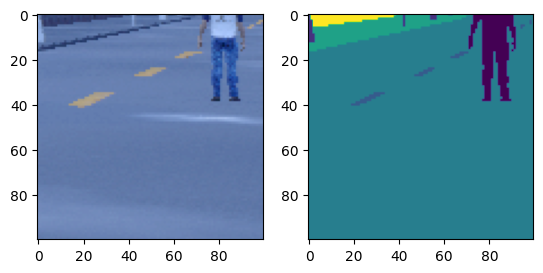

In [7]:
image, mask = dataset_train[random.randint(0,4000)]

fig, axs = plt.subplots(1,2)
axs[0].imshow(((image-image.min())/(image.max()-image.min())).permute((1,2,0)))
axs[1].imshow(mask)
plt.show()

## Estrai i migliori

In [ ]:
freqs = torch.tensor([3.223254919052124, 8.324562072753906, 80.07819366455078, 214.23089599609375, 5441.0986328125, 80.23406219482422, 74.35269927978516, 3.00116229057312, 14.900472640991211, 11.333002090454102, 404.04559326171875, 29.11901092529297, 995.0892333984375])
freqs = torch.tensor([0,0,0.1,0,1,0,0,0,0,0,0,0,0])
image, mask = dataset_train[random.randint(0,4000)]
scores = freqs[mask]

values = list()
indices = list()
size = 200
for x in range(0,mask.shape[0]-size,40):
    for y in range(0,mask.shape[1]-size,40):
        value = scores[x:x+size,y:y+size].sum().item()
        values.append(value)
        indices.append((y,x))

sorted_indices = [obj for _, obj in sorted(zip(values, indices), reverse=True)]

def calculate_iou(box1, box2):
    """
    Calcola l'Intersection over Union (IoU) tra due quadrati.
    box1 e box2 devono essere nel formato (i, j) dove (i, j) è il vertice superiore sinistro e il lato è 512.
    """
    side = 512  # Lunghezza del lato del quadrato

    # Coordinate per entrambi i quadrati
    x1_min, y1_min = box1
    x1_max, y1_max = box1[0] + side, box1[1] + side

    x2_min, y2_min = box2
    x2_max, y2_max = box2[0] + side, box2[1] + side

    # Calcolo delle coordinate dell'intersezione
    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    # Calcolo dell'area di intersezione
    inter_area = max(0, inter_x_max - inter_x_min) * max(0, inter_y_max - inter_y_min)

    # Area totale di entrambi i quadrati (lato fisso a 512)
    box_area = side * side
    union_area = 2 * box_area - inter_area

    # Calcolo dell'IoU
    iou = inter_area / union_area if union_area > 0 else 0
    return iou

def filter_squares(vertices, threshold=0.5):
    """
    Filtra una lista di quadrati (i, j) basandosi sull'IoU.
    Se IoU tra q_i e q_i+1 > threshold, q_i+1 viene eliminato.
    """
    filtered = [vertices[0]]  # Inizia dal primo quadrato
    for idx in range(1, len(vertices)):
        iou = 0
        for x in filtered:
            iou = max(iou, calculate_iou(x, vertices[idx]))
        if iou <= threshold:
            filtered.append(vertices[idx])  # Mantieni il quadrato solo se IoU è basso
    return filtered

sorted_indices = filter_squares(sorted_indices, threshold=0.3)
max_index = sorted_indices[0]#random.choice(sorted_indices)

image = (image-image.min())/(image.max()-image.min())
plt.imshow(FUNC.crop(image,max_index[1],max_index[0],size,size).permute(1,2,0))

'''
    for max_index in sorted_indices:
    plt.plot(
        [max_index[0],max_index[0]+size,max_index[0]+size,max_index[0],max_index[0]],
        [max_index[1],max_index[1],max_index[1]+size,max_index[1]+size,max_index[1]],
        '-',linewidth=2)
'''

plt.show()

Create Dataloader

In [9]:
num_workers = 2
batch_size = 8

dataloader_test = DataLoader(dataset_test,
                            batch_size=batch_size,
                            pin_memory=True,
                            num_workers=num_workers,
                            drop_last=True)

dataloader_test_anomaly = DataLoader(dataset_test_anomaly,
                            batch_size=batch_size,
                            pin_memory=True,
                            num_workers=num_workers,
                            drop_last=True)

print("Dataloader Creati")
print(f"Test batches: {len(dataloader_test)}")
print(f"Anomalies batches: {len(dataloader_test_anomaly)}\n")

Dataloader Creati
Test batches: 128
Anomalies batches: 59



# Results

Visual results

In [10]:
COLORS = np.array([
    [  0,   0,   0],  # unlabeled    =   0,
    [ 70,  70,  70],  # building     =   1,
    [190, 153, 153],  # fence        =   2, 
    [250, 170, 160],  # other        =   3,
    [220,  20,  60],  # pedestrian   =   4, 
    [153, 153, 153],  # pole         =   5,
    [157, 234,  50],  # road line    =   6, 
    [128,  64, 128],  # road         =   7,
    [244,  35, 232],  # sidewalk     =   8,
    [107, 142,  35],  # vegetation   =   9, 
    [  0,   0, 142],  # car          =  10,
    [102, 102, 156],  # wall         =  11, 
    [220, 220,   0],  # traffic sign =  12,
    [ 60, 250, 240],  # anomaly      =  13,
    [255, 255, 255],  #
])

def color(img_np: np.ndarray, colors: np.ndarray) -> Image.Image:
    img_new = np.zeros((img_np.shape[0],img_np.shape[1],3))

    for index, color in enumerate(colors):
        img_new[img_np == index] = color
    
    return Image.fromarray(img_new.astype("uint8"), "RGB")

def show_result(model:nn.Module, dataset:SegmentationDataset, idx:int):
    # Prepare image
    image, mask = dataset[idx]
    image = image.unsqueeze(dim=0).to(device)
    
    # Get output
    logit = model(image).squeeze()
    classes = torch.argmax(torch.nn.functional.softmax(logit, dim=0),dim=0)
    classes = torch.argmax(logit,dim=0)

    # Convert
    classes = classes.cpu().detach().numpy()
    mask = mask.cpu().detach().numpy()
    
    # Show results    
    fig, axs = plt.subplots(2,2,figsize=(8,4))
    axs[0,0].imshow(((image-image.min())/(image.max()-image.min())).squeeze().permute((1,2,0)).cpu().detach().numpy())
    axs[0,0].axis('off')
    axs[0,1].imshow((classes != mask), cmap='hot')
    axs[0,1].axis('off')
    axs[1,0].imshow(color(classes, COLORS))
    axs[1,0].axis('off')
    axs[1,1].imshow(color(mask, COLORS))
    axs[1,1].axis('off')
    plt.show()


In [11]:
class NormedConv(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, scale=1.0, margin=0.0, dilation=1, groups=1, bias=False, padding_mode='zeros', device=None, dtype=None):
        super(NormedConv, self).__init__(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias, padding_mode, device=device, dtype=dtype)
        self.scale = scale
        self.margin = margin

    def forward(self, x):
        # Normalizza i pesi lungo la dimensione dei filtri (output channels)
        norm_weight = torch.nn.functional.normalize(self.weight, p=2, dim=1)
        # Normalizza l'input lungo la dimensione dei canali (dim=1)
        norm_x = torch.nn.functional.normalize(x, p=2, dim=1)
        # Chiama il forward con input e pesi normalizzati
        return self.scale * torch.nn.functional.conv2d(norm_x, norm_weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

In [41]:
weights_path = '/raid/homespace/piecestola/space/ML4CV/results/train_6/ckpts/weights_mIoU_1.pt'

model = network.modeling.__dict__['deeplabv3plus_resnet101'](num_classes=21, output_stride=16)

# new norm_weights
head = PrototypeHeadArcFace2(256, [128], 13)

model.classifier.classifier[3] = head

model.load_state_dict(torch.load(weights_path, map_location=device)['model_state_dict'])
model.to(device)
model.eval()
print()

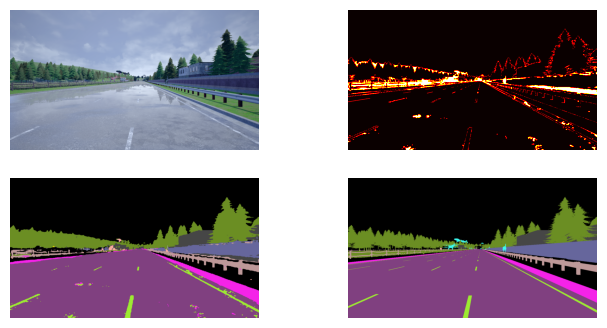

In [44]:
idx = random.randint(0,len(dataset_test_anomaly)-1)
show_result(model, dataset_test_anomaly, idx)

# Altro

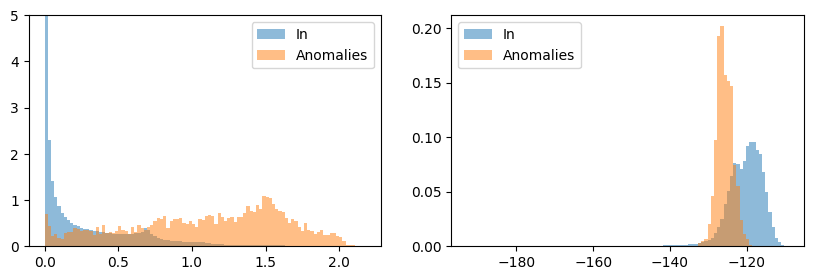

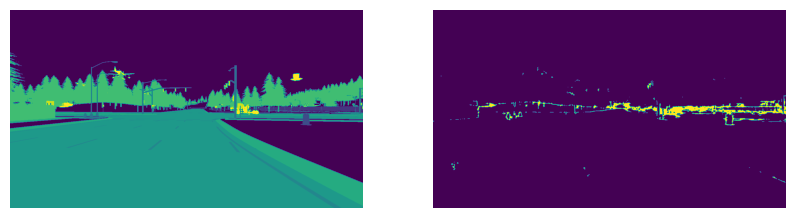

In [33]:
# Prepare image
import scipy.stats


image, mask = dataset_test_anomaly[167]
image = image.unsqueeze(dim=0).to(device)

# Get output
logit = model(image).squeeze()
prob = torch.nn.functional.softmax(logit, dim=0)
#prob = torch.sigmoid(logit)

# Convert
logit = logit.cpu().detach().numpy()
prob = prob.cpu().detach().numpy()
mask = mask.cpu().detach().numpy()

metrics = [
    scipy.stats.entropy(prob, axis=0),
    logit.max(axis=0)
]

bins = 100
fig,axs = plt.subplots(1,len(metrics),figsize=(5*len(metrics),3))
for i, metric in enumerate(metrics):
    minimum = metric.min()
    maximum = metric.max()
    axs[i].hist(metric[mask != 13], bins=bins, range=(minimum, maximum), alpha=0.5, density=True, label='In')
    axs[i].hist(metric[mask == 13], bins=bins, range=(minimum, maximum), alpha=0.5, density=True, label='Anomalies')
    if i == 0:
        axs[i].set_ylim((0,5))
    axs[i].legend()
#plt.show()

entropy = metrics[0]

# Show results
fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[1].imshow(entropy>1.2)
axs[1].axis('off')
axs[0].imshow(mask)
axs[0].axis('off')
plt.show()

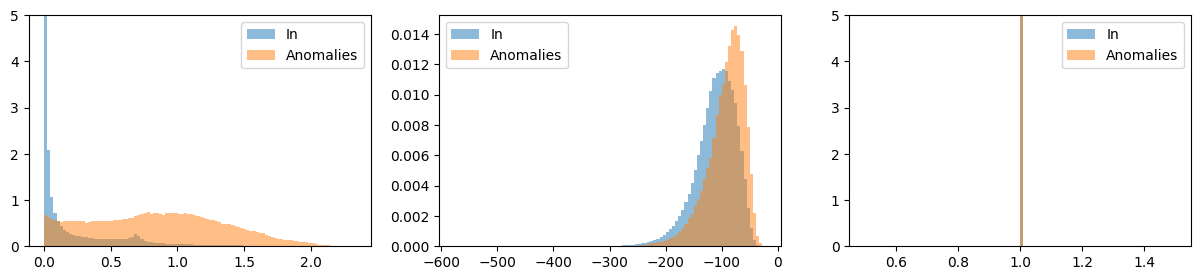

"\nfor idx in range(min(10, len(all_metrics))):  # Limita la visualizzazione per esempio\n    entropy = all_metrics[idx][0]\n    mask = all_masks[idx]\n    \n    fig, axs = plt.subplots(1, 2, figsize=(10, 5))\n    axs[1].imshow(entropy > 1.2)\n    axs[1].axis('off')\n    axs[0].imshow(mask)\n    axs[0].axis('off')\n    plt.show()\n"

In [19]:
gc.collect()
torch.cuda.empty_cache()

# Definizione delle liste per salvare i risultati
all_metrics = []
all_masks = []

#w = model.classifier.classifier[3].weight.squeeze()[0]

# Itera su tutto il dataset
for idx in range(20):
    # Estrai immagine e maschera
    image, mask = dataset_test_anomaly[idx]
    mask = mask.cpu().detach().numpy()

    image = image.unsqueeze(dim=0).to(device)
    
    # Ottieni l'output del modello
    logit = model(image).squeeze()
    del image

    prob = torch.softmax(logit, dim=0).cpu().detach().numpy()
    probs = torch.sigmoid(logit).cpu().detach().numpy()
    logit = logit.cpu().detach().numpy()
    
    # Calcola le metriche
    metrics = [
        scipy.stats.entropy(prob, axis=0),
        logit.max(axis=0),
        1-probs.max(axis=0)
        #np.linalg.norm(logit,axis=0)
    ]
    
    # Salva le metriche e la maschera
    all_metrics.append(metrics)
    all_masks.append(mask)

# Converte in array NumPy per un'analisi più semplice
all_metrics = np.array(all_metrics)
all_masks = np.array(all_masks)

# Visualizzazione dei risultati
bins = 100
fig, axs = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 3))
for i, metric in enumerate(metrics):
    # Combina i valori di tutte le immagini per le due classi
    metric_values_in = np.concatenate([all_metrics[j][i][all_masks[j] != 13] for j in range(len(all_metrics))])
    metric_values_anomalies = np.concatenate([all_metrics[j][i][all_masks[j] == 13] for j in range(len(all_metrics))])
    
    minimum = min(metric_values_in.min(), metric_values_anomalies.min())
    maximum = max(metric_values_in.max(), metric_values_anomalies.max())
    
    # Crea l'istogramma
    axs[i].hist(metric_values_in, bins=bins, range=(minimum, maximum), alpha=0.5, density=True, label='In')
    axs[i].hist(metric_values_anomalies, bins=bins, range=(minimum, maximum), alpha=0.5, density=True, label='Anomalies')
    
    if i != 1:
        axs[i].set_ylim((0, 5))
    axs[i].legend()
plt.show()

# Visualizzazione su singole immagini (opzionale)
'''
for idx in range(min(10, len(all_metrics))):  # Limita la visualizzazione per esempio
    entropy = all_metrics[idx][0]
    mask = all_masks[idx]
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[1].imshow(entropy > 1.2)
    axs[1].axis('off')
    axs[0].imshow(mask)
    axs[0].axis('off')
    plt.show()
'''

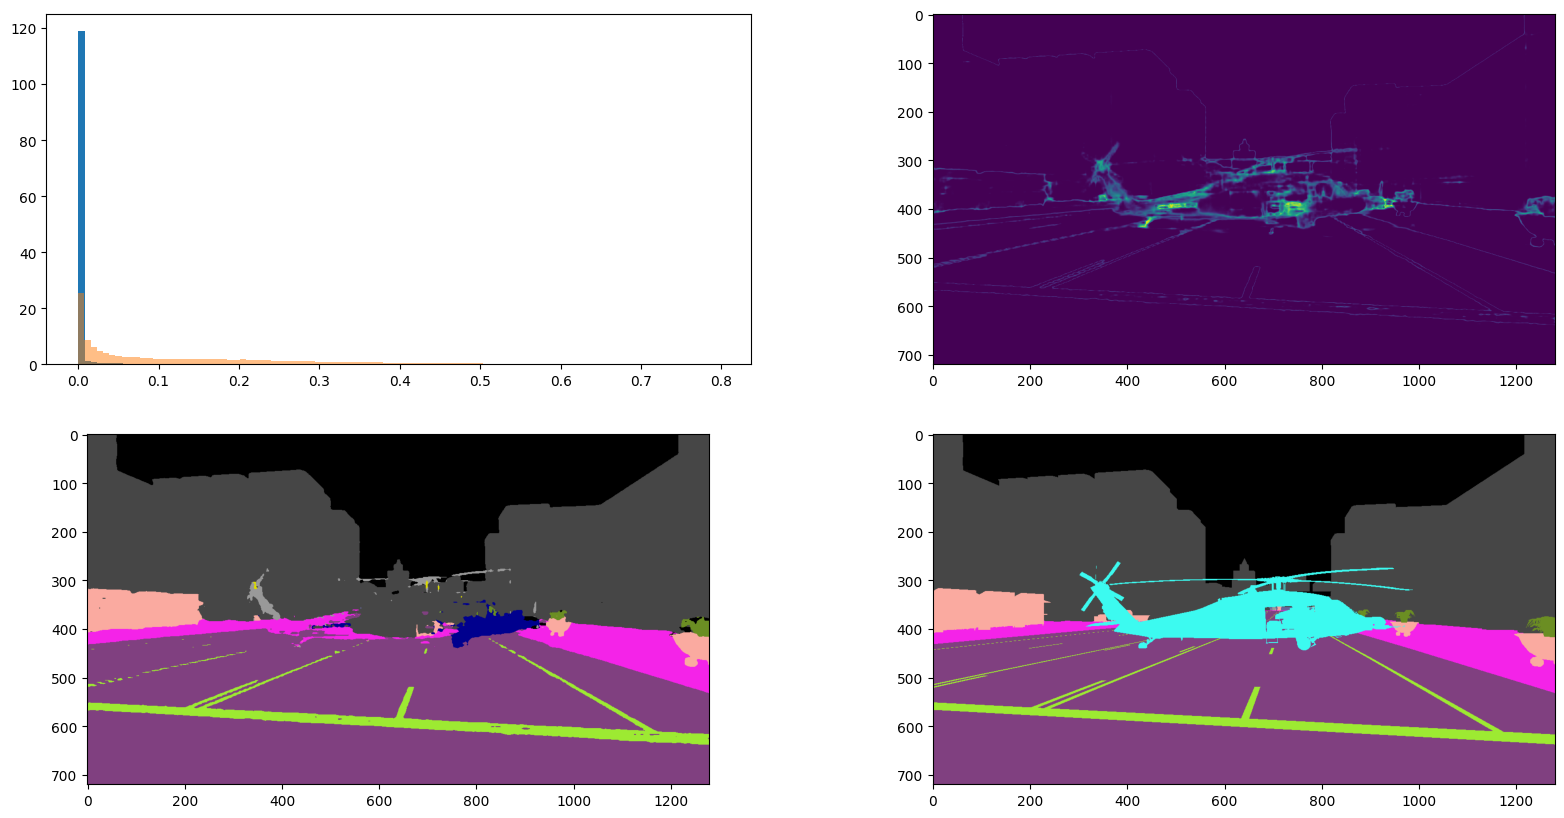

In [20]:
# Prepare image
import scipy.stats


image, mask = dataset_test_anomaly[0]
image = image.unsqueeze(dim=0).to(device)

# Get output
logit = model(image).squeeze()
prob = torch.nn.functional.softmax(logit, dim=0)
#prob = torch.sigmoid(logit)

# Convert
prob = prob.cpu().detach().numpy()
mask = mask.cpu().detach().numpy()
temp = mask.copy()

#mean = np.mean(prob[:,mask==13],axis=1)

entropy = scipy.stats.entropy(prob, axis=0)
entropy = (entropy-entropy.min())/(entropy.max()-entropy.min())
score = 1 - np.max(prob,axis=0)
#dist = np.sqrt(np.sum((prob - mean[:, np.newaxis, np.newaxis])**2, axis=0))
#dist = 1-(dist-dist.min())/(dist.max()-dist.min())
mask = mask.flatten()

fig, axs = plt.subplots(2,2,figsize=(20,10))
axs[0,0].hist(score.flatten()[mask!=13]*entropy.flatten()[mask!=13],100,density=True)
axs[0,0].hist(score.flatten()[mask==13]*entropy.flatten()[mask==13],100,density=True,alpha=0.5)
axs[0,1].imshow(score*entropy)
axs[1,0].imshow(color(torch.argmax(logit,dim=0).detach().cpu().numpy(),COLORS))
axs[1,1].imshow(color(temp,COLORS))
plt.show()

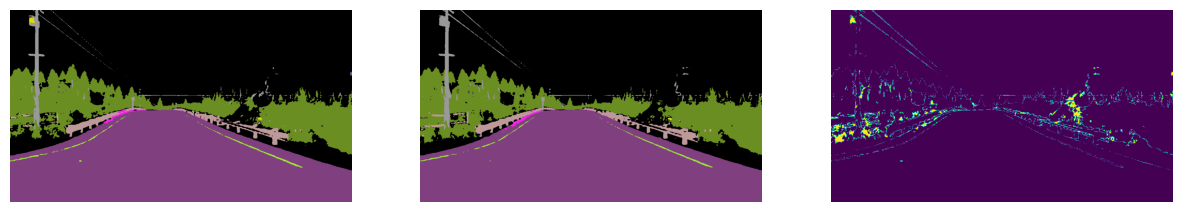

In [21]:
image, mask = dataset_test_anomaly[2]
image = image.to(device)
image_hflipped = torchvision.transforms.functional.hflip(image)
image_vflipped = torchvision.transforms.functional.vflip(image)

image = torch.argmax(model(image.unsqueeze(dim=0)).squeeze(),dim=0)
image_hflipped = torch.argmax(model(image_hflipped.unsqueeze(dim=0)).squeeze(),dim=0)
image_vflipped = torch.argmax(model(image_vflipped.unsqueeze(dim=0)).squeeze(),dim=0)
image_hflipped = torchvision.transforms.functional.hflip(image_hflipped)
image_vflipped = torchvision.transforms.functional.vflip(image_vflipped)

image = image.cpu().detach().numpy()
image_hflipped = image_hflipped.cpu().detach().numpy()
image_vflipped = image_vflipped.cpu().detach().numpy()

_, axs = plt.subplots(1,3,figsize=(15,5))
axs[0].imshow(color(image, COLORS))
axs[1].imshow(color(image_hflipped, COLORS))
axs[2].imshow(image!=image_hflipped)
for i in range(3):  axs[i].axis('off')
plt.show()

# Test personale

In [33]:
# Hook per il penultimo strato
def hook_fn(module, input, output):
    global saved_act
    saved_act = output

In [ ]:
# Prepare image
idx = 0
image, mask = dataset_test_anomaly[idx]
image = image.unsqueeze(dim=0).to(device)

# Registra l'hook sul penultimo strato
hook_handle = model.classifier.classifier[2].register_forward_hook(hook_fn)

# Get output
logit = model(image).squeeze()
#print(torch.round(torch.sigmoid(logit[:,300,300]),decimals=3))
classes = torch.argmax(torch.nn.functional.softmax(logit, dim=0),dim=0)

# Convert
saved_act = saved_act.cpu().detach().squeeze().numpy()
classes = classes.cpu().detach().numpy()
mask = mask.cpu().detach().numpy()

# Le attivazioni del penultimo strato sono ora salvate in `penultimate_activations`
print("Attivazioni del penultimo strato:", saved_act.shape)

# Rimuovi l'hook quando non serve più
hook_handle.remove()

temp = saved_act.transpose((1,2,0))
temp = temp.reshape((-1,256))
print(temp.shape)

# Sanity check
#print((temp[320] == saved_act[:,1,0]).all())

In [41]:
classe = 1

# Dimensioni di img1 e img2
h1, w1 = 180, 320  # img1
h2, w2 = 720, 1280  # img2
scale = 4

# 1. Trova gli indici in cui img2 è uguale a c
indices_mask = np.where(classes == classe)

# 2. Converti le coordinate 2D di img2 in quelle di img1
i_mask, j_mask = indices_mask
i_temp = i_mask // scale
j_temp = j_mask // scale

# 3. Converti le coordinate di img1 in indici 1D
indices_temp = i_temp * w1 + j_temp

In [ ]:
# Normalizzo
temp_ = temp[indices_temp]
mean_ = temp_.mean(axis=0)
mean_ /= np.linalg.norm(mean_)
temp_ = temp_ / np.linalg.norm(temp_, axis=1, keepdims=True)

# Calcolo del prodotto scalare con broadcasting
dot_products = np.dot(temp_, mean_)

# indici simili
soglia = 2.2* dot_products.min()
indices_anomalies = np.where(dot_products<soglia)[0].flatten()
classes_ = np.zeros(classes.shape)
classes_[i_mask[indices_anomalies], j_mask[indices_anomalies]] = 13

plt.imshow(color(classes_, COLORS_ANOMALY))
plt.show()

In [ ]:
show_result(model, dataset_test_anomaly, 0)

# Check

In [10]:
vectors = [model.classifier.classifier[3][1].weight[i].detach().cpu().squeeze().numpy() for i in range(13)]

def rgb2hex(color):
    r,g,b = color
    return "#{:02x}{:02x}{:02x}".format(r,g,b)

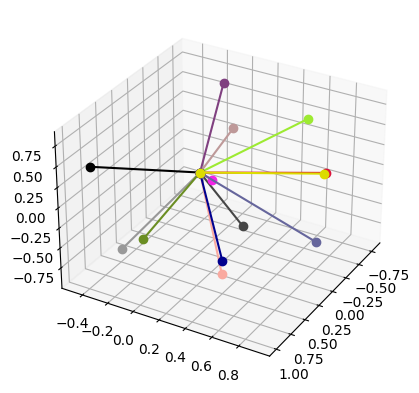

: 

In [18]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.cla()

#circle = plt.Circle((0, 0), 1, color='k', fill=False)
#ax.add_patch(circle)

for i, vector in enumerate(vectors):
    vector = vector / np.linalg.norm(vector)
    plt.plot([0,vector[0]],[0,vector[1]],[0,vector[2]],'-o',color=rgb2hex(COLORS[i]))

'''
#layer_output = torch.nn.functional.interpolate(layer_output, size=(720,1280), mode='bilinear', align_corners=False)

### Hook
def hook_fn(module, input, output):
    global layer_output
    interpolated_output = torch.nn.functional.interpolate(output, scale_factor=4, mode='bilinear', align_corners=False)
    layer_output = interpolated_output.squeeze().detach().cpu().numpy().reshape((2,-1))

# Registra l'hook
hook = model.classifier.classifier[3][0].register_forward_hook(hook_fn)

# Esegui una forward pass
image, mask = dataset_test_anomaly[0]
_ = model(image.unsqueeze(dim=0).to(device))

# Rimuovi il hook per evitare effetti collaterali
hook.remove()
### Hook

mask = mask.numpy().reshape(-1)

norms = np.linalg.norm(layer_output, axis=0, keepdims=True)
layer_output = layer_output / 2 / norms

idx = 11
points = layer_output[:,mask==idx]
plt.plot(points[:,:100][0],points[:,:100][1],'x',color=rgb2hex(COLORS[idx]))
'''

#plt.axis('equal')
ax.view_init(elev=30, azim=30)
plt.show()